In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib  
from matplotlib import rcParams 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
color = sns.color_palette()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy import sparse
import xgboost as xgb
from sklearn import metrics,model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
import string
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import hstack
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

In [ ]:
train_df = pd.read_excel('/content/drive/MyDrive/Text_Analytics/Group Assignment/Train.xlsx')
test_df = pd.read_excel('/content/drive/MyDrive/Text_Analytics/Group Assignment/Test.xlsx')
train_df.head()

,building_id,created,description,features,latitude,longitude,bathrooms,bedrooms,price,interest_level
0,0,2016-05-22 05:21:55,This is a terrric large one bedroom apartment ...,"['Garden/Patio', 'Dishwasher', 'Hardwood Floors']",40.6926,-73.9259,1.0,1,1750,high
1,0,2016-06-14 15:19:45,"BRAND NEW FULL SERVICE LUXURY BUILDING, CENTRA...","['Roof Deck', 'Balcony', 'Doorman', 'Elevator'...",40.7520,-73.9402,1.0,0,2123,high
2,0,2016-04-18 14:48:46,OMG!!! E 85th/2ND**MASSIVE**EXP BRICK**SEP KIT...,"['Cats Allowed', 'Dogs Allowed']",40.7740,-73.9546,1.0,0,1750,high
3,0,2016-06-02 01:27:38,**West Village- Leroy Street** Super renovated...,"['Fireplace', 'Pre-War', 'Dogs Allowed', 'Cats...",40.7304,-74.0050,1.0,1,3495,high
4,0,2016-05-10 16:35:53,267 Edgecombe Ave. ...,[],40.7128,-74.0059,1.0,0,1450,high


# **1. Data description**

This part we will learn the data to understand the data better.

There are 8686 observations, 10 variables. interest_level is the response variable to predict with 3 values： high, medium and low. bathrooms, bedrooms, latitude, longitude, price are the numeric variables. For apartments, it is likely the cheaper and less bedrooms will be more popular. We can check this later. Description and features are the text description or labels about the property.

**1.1. Distribution of interest_level**

In [ ]:
train_df.interest_level.value_counts(dropna = False)

low       6138
medium    1867
high       681
Name: interest_level, dtype: int64

The response variable interest_level is character with 3 levels, there is no missing value.

**1.2. Check the distribution / missing of numeric variables**

In [ ]:
train_df.describe()

,latitude,longitude,bathrooms,bedrooms,price
count,8686.000000,8686.000000,8686.000000,8686.000000,8.686000e+03
mean,40.747606,-73.962868,1.211835,1.525673,3.919965e+03
std,0.442614,0.796833,0.517481,1.119553,1.696697e+04
min,0.000000,-76.633600,0.000000,0.000000,6.950000e+02
25%,40.728725,-73.991400,1.000000,1.000000,2.495000e+03
50%,40.751950,-73.977700,1.000000,1.000000,3.113000e+03
75%,40.774600,-73.954500,1.000000,2.000000,4.075000e+03
max,44.603800,0.000000,10.000000,7.000000,1.150000e+06


There is no missing value for the numeric variables, but there are some outliers.

There is max of bathrooms is 10 and the max of bedrooms is 7. The min of bathrooms and bedrooms are 0. Are they condo? Min of latitude is 0 and max is 44.6. Latitude is mostly around 40.7. Min of longitude is -76.63 and max is 0. Most of longitude is around -73.9. Min of price is 695 and max is 1.15MN. It is very likely latitude, longitude and price has ourliers.

**Latitude**

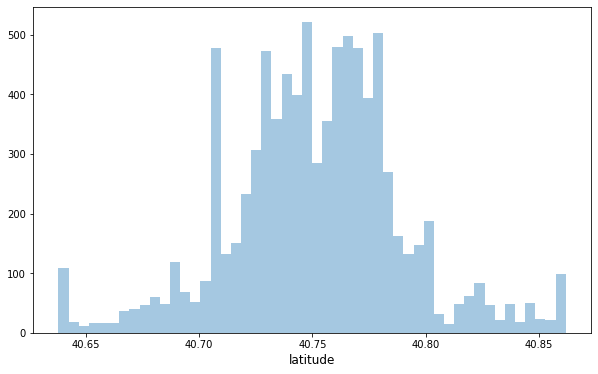

In [ ]:
llimit = np.percentile(train_df.latitude.values, 1)
ulimit = np.percentile(train_df.latitude.values, 99)
train_df['latitude'].loc[train_df['latitude']<llimit] = llimit
train_df['latitude'].loc[train_df['latitude']>ulimit] = ulimit
plt.figure(figsize=(10,6))
sns.distplot(train_df.latitude.values, bins=50, kde=False)
plt.xlabel('latitude', fontsize=12)
plt.show()

**Longitude**

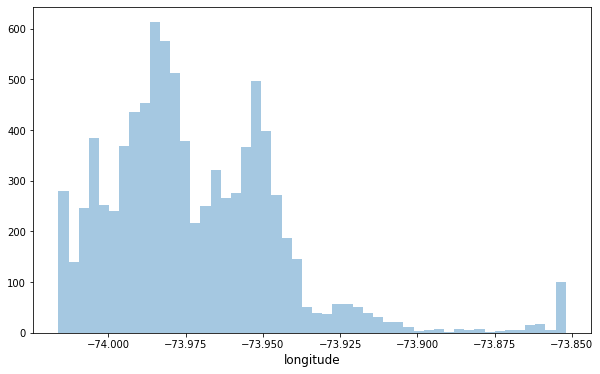

In [ ]:
llimit = np.percentile(train_df.longitude.values, 1)
ulimit = np.percentile(train_df.longitude.values, 99)
train_df['longitude'].loc[train_df['longitude']<llimit] = llimit
train_df['longitude'].loc[train_df['longitude']>ulimit] = ulimit
plt.figure(figsize=(10,6))
sns.distplot(train_df.longitude.values, bins=50, kde=False)
plt.xlabel('longitude', fontsize=12)
plt.show()

**Interest Level**

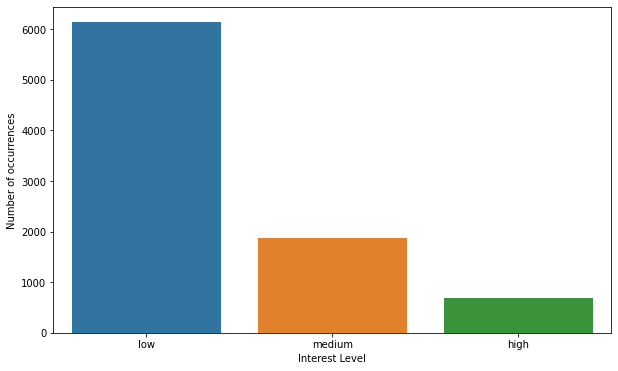

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(train_df.interest_level, order=['low', 'medium', 'high']);
plt.xlabel('Interest Level');
plt.ylabel('Number of occurrences');

**Bathrooms**

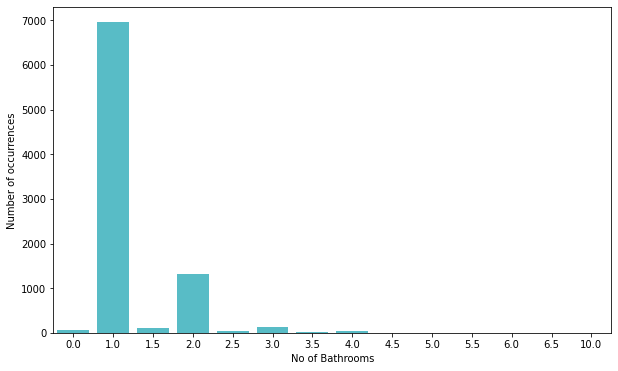

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(train_df.bathrooms,alpha = 0.8,color=color[9]);
plt.xlabel('No of Bathrooms');
plt.ylabel('Number of occurrences');


**Bedrooms**

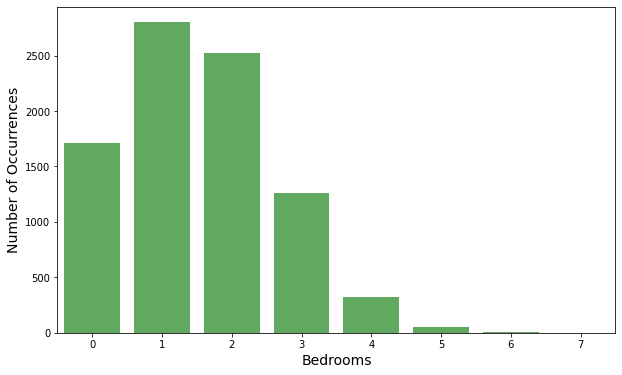

In [ ]:
cnt_srs = train_df['bedrooms'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Bedrooms', fontsize=14)
plt.show()

**Bedrooms feature with Interest Levels**

For each number of bedrooms(0, 1, 2...) we can count how many times high/low/medium occurs. From the graph below, the 1 bedroom occurs most, next by two bedrooms, and then 0 bedrooms. For each of these, low appers most, then medium. hign appears least.

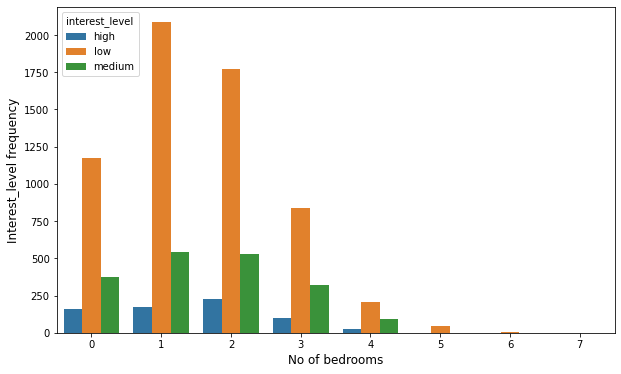

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='bedrooms', hue='interest_level', data=train_df)
plt.ylabel('Interest_level frequency', fontsize=12)
plt.xlabel('No of bedrooms', fontsize=12)
plt.show()

But this only tell us the counts. It does not tell us the distribution of interest_level on different bedrooms. Next we will calculate the percentage.

From the analysis, we can find low rate is a little high on bedroom=1 than the others from 0 to 4. On 5, 6, 7 and 8, the low rate is very high which is almost 1. So we can have the rough conclusion that if bedrooms is more than or equal to 5, it is very likely it will be low interest.

Text(0, 0.5, 'percentage*100')

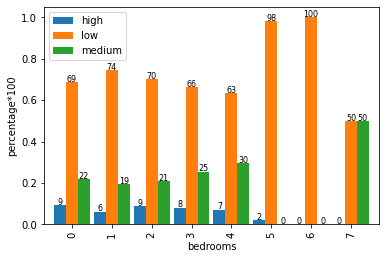

In [ ]:
f = lambda x: x.value_counts()/x.shape[0]
s = train_df.groupby('bedrooms').interest_level.apply(f)
s = s.unstack(level = -1)

fig, ax = plt.subplots()
s.plot.bar(width = .9, ax = ax)
for p in ax.patches: 
    ax.annotate(int(np.round(p.get_height()*100)), (p.get_x()+p.get_width()/2., p.get_height()), \
                ha='center', va='center', xytext=(0, 3), size = 8, textcoords='offset points') 

plt.legend(loc = 0)
plt.ylabel("percentage*100")

**Price**

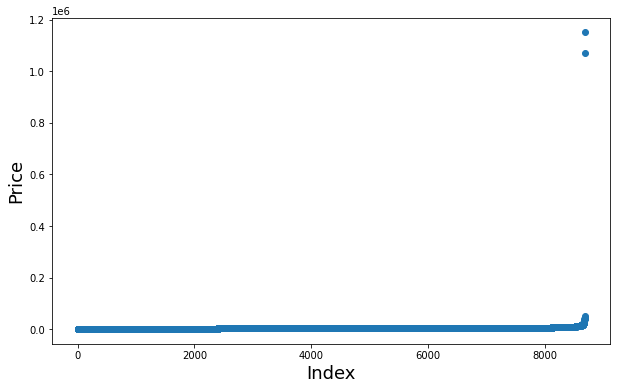

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price.values))
plt.xlabel('Index', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

Looks like there are some outliers in this feature. So let us remove them and then plot again

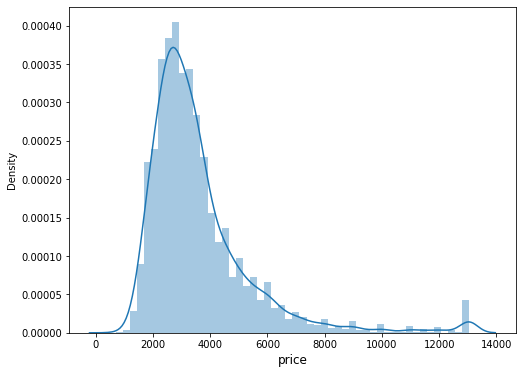

In [ ]:
ulimit = np.percentile(train_df.price.values, 99)
train_df['price'].loc[train_df['price']>ulimit] = ulimit
plt.figure(figsize=(8,6))
sns.distplot(train_df.price.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

 We can see that the distribution is right skewed.

**Word Clouds:text features**

In [ ]:
train_df['description'] = train_df['description'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
train_df['description'] = train_df['description'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
train_df['description'] = train_df['description'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
train_df['description'] = train_df['description'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
train_df['description'] = train_df['description'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
train_df['description'] = train_df['description'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
train_df['description'] = train_df['description'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
train_df['description'] = train_df['description'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
train_df['description'] = train_df['description'].str.lower()

# remove non alphabets with whitespace
train_df['description'] = train_df['description'].str.replace(r'[^a-zA-Z]', ' ')

train_df['description'] = train_df['description'].str.replace(r'br', ' ')
train_df['description'] = train_df['description'].str.replace(r'href', ' ')


In [ ]:
test_df['description'] = test_df['description'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
test_df['description'] = test_df['description'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
test_df['description'] = test_df['description'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
test_df['description'] = test_df['description'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
test_df['description'] = test_df['description'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
test_df['description'] = test_df['description'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
test_df['description'] = test_df['description'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
test_df['description'] = test_df['description'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
test_df['description'] = test_df['description'].str.lower()

# remove non alphabets with whitespace
test_df['description'] = test_df['description'].str.replace(r'[^a-zA-Z]', ' ')

test_df['description'] = test_df['description'].str.replace(r'br', ' ')
test_df['description'] = test_df['description'].str.replace(r'href', ' ')

In [ ]:
data_desc = pd.DataFrame(train_df['description'])

In [ ]:
import wordcloud
def show_wordcloud(data, title):
    text = ' '.join(train_df['description'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, background_color="#FFFAF0",
                                        width = 3000, height = 2000).generate(text)
    plt.figure(figsize=(15,15), frameon=False)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

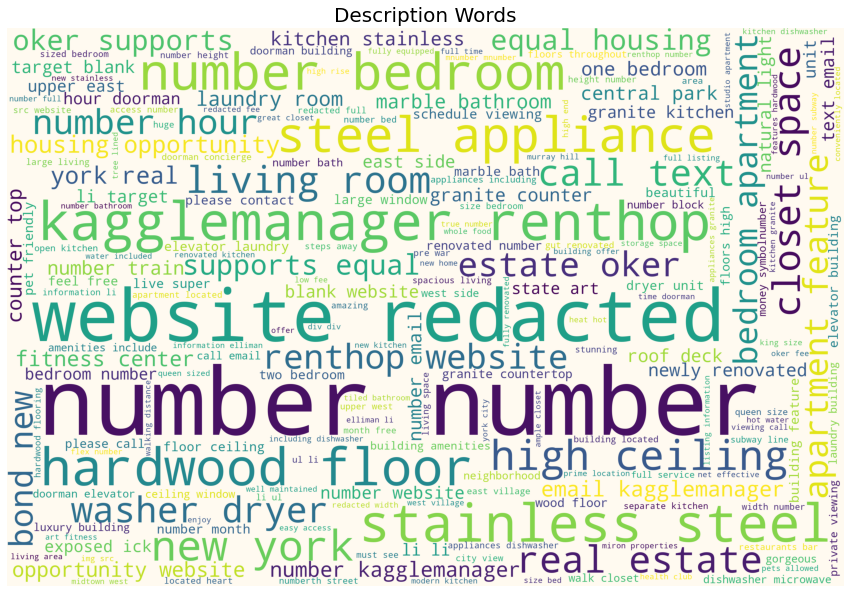

In [ ]:
show_wordcloud(data_desc, "Description Words")

In [ ]:
train_df['features'] = train_df['features'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
train_df['features'] = train_df['features'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
train_df['features'] = train_df['features'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
train_df['features'] = train_df['features'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
train_df['features'] = train_df['features'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
train_df['features'] = train_df['features'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
train_df['features'] = train_df['features'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
train_df['features'] = train_df['features'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
train_df['features'] = train_df['features'].str.lower()

# remove non alphabets with whitespace
train_df['features'] = train_df['features'].str.replace(r'[^a-zA-Z]', ' ')

train_df['features'] = train_df['features'].str.replace(r'br', ' ')
train_df['features'] = train_df['features'].str.replace(r'href', ' ')

In [ ]:
test_df['features'] = test_df['features'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
test_df['features'] = test_df['features'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
test_df['features'] = test_df['features'].str.replace(r'£|\$', 'money-symbol')

# Replace 10 digit phone number with 'phone-number'
test_df['features'] = test_df['features'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone-number')

# Replace normal number with 'number'
test_df['features'] = test_df['features'].str.replace(r'\d+(\.\d+)?', 'number')

# remove punctuation
test_df['features'] = test_df['features'].str.replace(r'[^\w\d\s]', ' ')

# remove whitespace between terms with single space
test_df['features'] = test_df['features'].str.replace(r'\s+', ' ')

# remove leading and trailing whitespace
test_df['features'] = test_df['features'].str.replace(r'^\s+|\s*?$', ' ')

# change words to lower case
test_df['features'] = test_df['features'].str.lower()

# remove non alphabets with whitespace
test_df['features'] = test_df['features'].str.replace(r'[^a-zA-Z]', ' ')

test_df['features'] = test_df['features'].str.replace(r'br', ' ')
test_df['features'] = test_df['features'].str.replace(r'href', ' ')

In [ ]:
data_feat = pd.DataFrame(train_df['features'])

In [ ]:
import wordcloud
def show_wordcloud(data, title):
    text = ' '.join(train_df['features'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, background_color="#FFFAF0",
                                        width = 3000, height = 2000).generate(text)
    plt.figure(figsize=(15,15), frameon=False)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

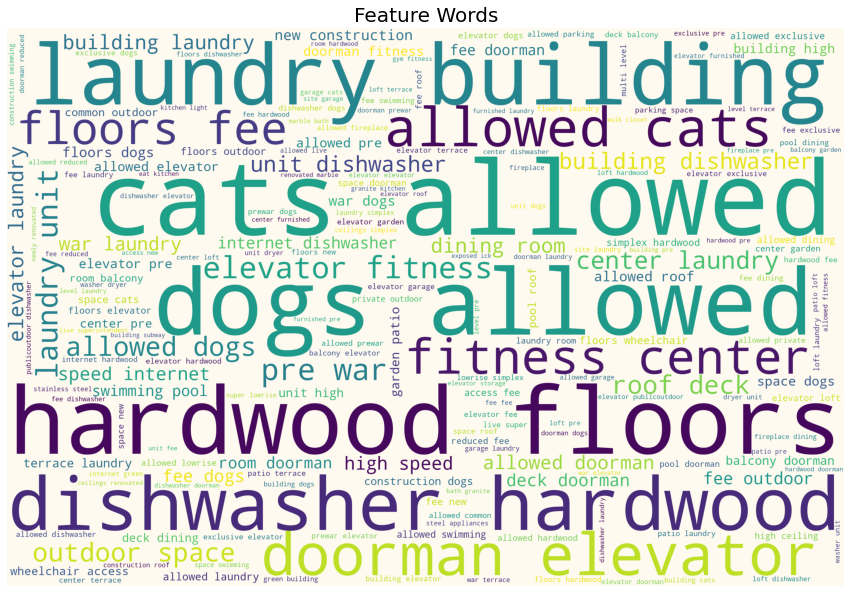

In [ ]:
show_wordcloud(data_feat, "Feature Words")

In [ ]:
features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price"]

In [ ]:
# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)


train_df['description']=train_df['description'].fillna("")
test_df['description']=test_df['description'].fillna("")
# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))
# convert the created column to datetime object so as to extract more features 
train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])
# Let us extract some features like year, month, day, hour from date columns #
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour
# adding all these new features to use list #
features_to_use.extend([ "num_features", "num_description_words","created_year", "created_month", "created_day", "created_hour"])
train_df.head(2)



,building_id,created,description,features,latitude,longitude,bathrooms,bedrooms,price,interest_level,num_features,num_description_words,created_year,created_month,created_day,created_hour
0,0,2016-05-22 05:21:55,this is a terrric large one bedroom apartment ...,garden patio dishwasher hardwood floors,40.6926,-73.9259,1.0,1,1750.0,high,42,121,2016,5,22,5
1,0,2016-06-14 15:19:45,and new full service luxury building centrall...,roof deck balcony doorman elevator fitness ce...,40.7520,-73.9402,1.0,0,2123.0,high,162,171,2016,6,14,15


In [ ]:
# adding all these new features to use list #
features_to_use.extend([ "num_features", "num_description_words","created_year", "created_month", "created_day", "created_hour"])

We have features column which is a list of string values. So we can first combine all the strings together to get a single string and then apply count vectorizer on top of it.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# list of text documents
text = train_df['features']

vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)

print(vectorizer.vocabulary_)

# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'garden': 193, 'patio': 344, 'dishwasher': 129, 'hardwood': 212, 'floors': 178, 'roof': 379, 'deck': 119, 'balcony': 39, 'doorman': 132, 'elevator': 147, 'fitness': 175, 'center': 78, 'laundry': 257, 'in': 233, 'building': 65, 'high': 219, 'speed': 417, 'internet': 241, 'new': 308, 'construction': 109, 'dogs': 131, 'allowed': 11, 'cats': 74, 'fireplace': 174, 'pre': 356, 'war': 502, 'furnished': 188, 'dining': 125, 'room': 382, 'loft': 272, 'multi': 304, 'level': 259, 'terrace': 457, 'unit': 481, 'outdoor': 332, 'space': 413, 'no': 310, 'fee': 166, 'wheelchair': 506, 'access': 3, 'ceilings': 77, 'renovated': 371, 'marble': 285, 'bath': 43, 'granite': 201, 'kitchen': 252, 'light': 262, 'private': 359, 'swimming': 450, 'pool': 354, 'common': 99, 'parking': 341, 'children': 84, 'pet': 349, 'friendly': 184, 'water': 504, 'view': 495, 'numberhr': 313, 'doormen': 133, 'package': 337, 'service': 391, 'dry': 135, 'cleaning': 91, 'washer': 503, 'dryer': 136, 'stainless': 426, 'steel': 431, 'ex

In [ ]:
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

Now let us stack both the dense and sparse features into a single dataset and also get the target variable.

In [ ]:
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()
target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

(8686, 218) (2171, 218)


In [ ]:
# Spliting data into train and cross validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_X,train_y, test_size=0.2, random_state=18)
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42)
x_train y_train = sm.fit_resample(x_train, y_train)

# **K Nearest Neighbour Classification**

**Hyper parameter tuning**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score


alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print( "for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_val) 
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
# to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_val, sig_clf_probs))

for alpha = 5
Log Loss : 0.7200439609268322
for alpha = 11
Log Loss : 0.7055557793823055
for alpha = 15
Log Loss : 0.7002455220268043
for alpha = 21
Log Loss : 0.6961542488787976
for alpha = 31
Log Loss : 0.6899246939493416
for alpha = 41
Log Loss : 0.6862056862139406
for alpha = 51
Log Loss : 0.6873014783511288
for alpha = 99
Log Loss : 0.6902312432822897


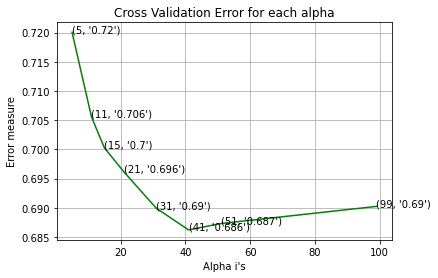

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
  ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(algorithm='auto',
                                                           leaf_size=30,
                                                           metric='minkowski',
                                                           metric_params=None,
                                                           n_jobs=None,
                                                           n_neighbors=41, p=2,
                                                           weights='uniform'),
                       cv=None, method='sigmoid')

In [ ]:
predict_y_knn_train = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y_knn_train, labels=clf.classes_, eps=1e-15))
predict_y_knn_cross_validation = sig_clf.predict_proba(x_val)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y_knn_cross_validation, labels=clf.classes_, eps=1e-15))
predict_y_knn_test = sig_clf.predict_proba(test_X)

For values of best alpha =  41 The train log loss is: 0.6794074434422633
For values of best alpha =  41 The cross validation log loss is: 0.6862056862139406


# **Logistic regression**

**Hyper parameter tuning**

In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

for i in alpha:
  print("for alpha =", i)
  clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
  clf.fit(x_train, y_train)
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(x_train, y_train)
  sig_clf_probs = sig_clf.predict_proba(x_val)
  cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
# to avoid rounding error while multiplying probabilites we use log-probability estimates
  print("Log Loss :",log_loss(y_val, sig_clf_probs))

for alpha = 1e-06
Log Loss : 0.7650445331841659
for alpha = 1e-05
Log Loss : 0.7650445331841659
for alpha = 0.0001
Log Loss : 0.7650445331841659
for alpha = 0.001
Log Loss : 0.7650445331841659
for alpha = 0.01
Log Loss : 0.70816728889769
for alpha = 0.1
Log Loss : 0.7049166663678427
for alpha = 1
Log Loss : 0.7083110449865728
for alpha = 10
Log Loss : 0.7059574791720735
for alpha = 100
Log Loss : 0.7076560305797566


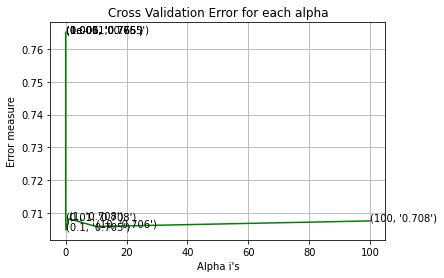

In [ ]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
  ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.1, average=False,
                                                    class_weight='balanced',
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                       

In [ ]:
predict_y_Logistic_train = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y_Logistic_train, labels=clf.classes_, eps=1e-15))
predict_y_Logistic_cross_validation = sig_clf.predict_proba(x_val)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y_Logistic_cross_validation, labels=clf.classes_, eps=1e-15))
predict_y_Logistic_test = sig_clf.predict_proba(test_X)

For values of best alpha =  0.1 The train log loss is: 0.7108312293772219
For values of best alpha =  0.1 The cross validation log loss is: 0.7049166663678427


# **Random Forest Classifier**

**Hyper paramter tuning**

In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
  for j in max_depth:
    print("for n_estimators =", i,"and max depth = ", j)
    clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_val)
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_val, sig_clf_probs))


for n_estimators = 100 and max depth =  5
Log Loss : 0.6370958726942697
for n_estimators = 100 and max depth =  10
Log Loss : 0.6228896560904884
for n_estimators = 200 and max depth =  5
Log Loss : 0.6378140388680923
for n_estimators = 200 and max depth =  10
Log Loss : 0.6213906394795939
for n_estimators = 500 and max depth =  5
Log Loss : 0.6376118152023386
for n_estimators = 500 and max depth =  10
Log Loss : 0.6207370219920085
for n_estimators = 1000 and max depth =  5
Log Loss : 0.637865780024179
for n_estimators = 1000 and max depth =  10
Log Loss : 0.6204198705196258
for n_estimators = 2000 and max depth =  5
Log Loss : 0.6377833795185112
for n_estimators = 2000 and max depth =  10
Log Loss : 0.6207998300545882


In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                                 

In [ ]:
predict_y_RF_train = sig_clf.predict_proba(x_train)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y_RF_train, labels=clf.classes_, eps=1e-15))
predict_y_RF_cross_validation = sig_clf.predict_proba(x_val)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_val, predict_y_RF_cross_validation, labels=clf.classes_, eps=1e-15))
predict_y_RF_test = sig_clf.predict_proba(test_X)

For values of best estimator =  1000 The train log loss is: 0.4745866664571348
For values of best estimator =  1000 The cross validation log loss is: 0.6204198705196258


# **XGB Boost Classifier**

**Hyper parameter Tuning**

In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


alpha = [100,200,500,1000]
max_depth = [5, 10]
alpha = [100,200,500,1000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
  for j in max_depth:
    print("for n_estimators =", i,"and max depth = ", j)
    clf = XGBClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_val)
    cv_log_error_array.append(log_loss(y_val, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_val, sig_clf_probs))

for n_estimators = 100 and max depth =  5
Log Loss : 0.5868799789826683
for n_estimators = 100 and max depth =  10
Log Loss : 0.612977555694773
for n_estimators = 200 and max depth =  5
Log Loss : 0.5889652862895963
for n_estimators = 200 and max depth =  10
Log Loss : 0.6249991781225889
for n_estimators = 500 and max depth =  5
Log Loss : 0.609863828211621
for n_estimators = 500 and max depth =  10
Log Loss : 0.6364062701544562
for n_estimators = 1000 and max depth =  5
Log Loss : 0.6271611799954183
for n_estimators = 1000 and max depth =  10
Log Loss : 0.6414415388640233


In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = XGBClassifier(n_estimators=100, criterion='gini', max_depth=5, random_state=42, n_jobs=-1)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=1,
                                                    criterion='gini', gamma=0,
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=5,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=100, n_jobs=-1,
                                                    nthread=None,
                                                    objective='multi:softpr

In [ ]:
predict_y_XGB_train = sig_clf.predict_proba(x_train)
print('For values of best estimator = 100', "The train log loss is:",log_loss(y_train, predict_y_XGB_train, labels=clf.classes_, eps=1e-15))
predict_y_XGB_cross_validation = sig_clf.predict_proba(x_val)
print('For values of best estimator = 100', "The cross validation log loss is:",log_loss(y_val, predict_y_XGB_cross_validation, labels=clf.classes_, eps=1e-15))
predict_y_XGB_test = sig_clf.predict_proba(test_X)

For values of best estimator = 100 The train log loss is: 0.4525305779865499
For values of best estimator = 100 The cross validation log loss is: 0.5868799789826683


In [ ]:
import pandas as pd
 
# initialize data of lists.
data = {'Model':['KNN Classifier', 'Logistic Regression Classifier', 'Random Forest Classifier', 'XGB Boost Classifier'],
        'Train log loss':[0.679,0.71,0.474,0.452],
        'Cross Validation log loss':[0.686,0.70,0.620,0.586]}
 
# Create DataFrame
Results = pd.DataFrame(data)
 
# Print the output.
Results

,Model,Train log loss,Cross Validation log loss
0,KNN Classifier,0.679,0.686
1,Logistic Regression Classifier,0.710,0.700
2,Random Forest Classifier,0.474,0.620
3,XGB Boost Classifier,0.452,0.586
